# 무신사 상품 리뷰 크롤링(crawrling)

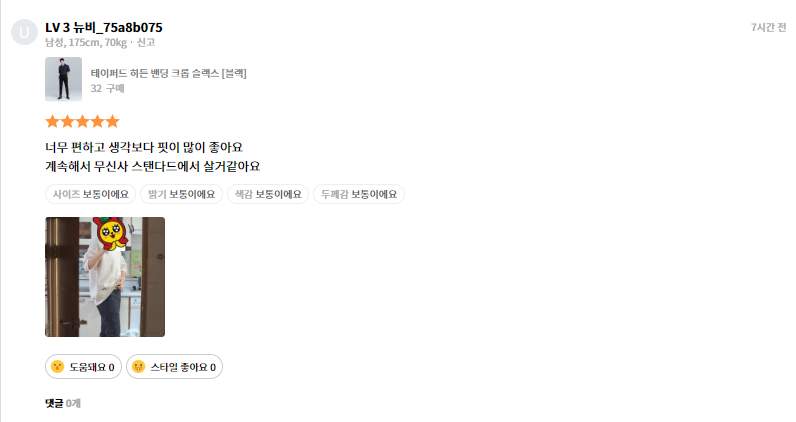

* ↑크롤링할 리뷰 구조 

## 환경설정

In [1]:
#필요하면 설치하기
#!pip install webdriver-manager
#from selenium import webdriver
#from webdriver_manager.chrome import ChromeDriverManager
#driver = webdriver.Chrome(ChromeDriverManager().install())
#!pip install selenium

In [2]:
from selenium import webdriver
from bs4 import BeautifulSoup
import time
import re
import time
import pandas as pd
import warnings
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
warnings.filterwarnings("ignore") 

In [3]:
#함수정의:검색어 조건에 따른 url생성
#무신사 스탠다드->후기순->벨트 및 양말 등 잡화제외 1위 상품
#def musinsa_searching(word):
#  url = "https://www.musinsa.com/app/goods/1149328" 
#  return url

In [4]:
#driver = webdriver.Chrome('chromedriver.exe')
#위치: C:\Users\rlawndms\boaz_삭제절대금지
#무신사 스탠다드->후기순(스타일후기)->벨트 및 양말 등 잡화제외 1위 상품
driver = webdriver.Chrome(executable_path='C:/Users/rlawndms/boaz_삭제절대금지/chromedriver.exe')
#해당 상품 링크_필요할때마다 링크 바꿔주기
driver.get('https://www.musinsa.com/app/goods/1149328')
time.sleep(3)

In [5]:
# 할인쿠폰 창 없애기->그냥 수동으로 했음

## 함수정의 
* 리뷰크롤링
* 페이지이동

In [6]:
#user, gender,height,weight,item, size,content, evaluation(size_eval,bright_eval,color_eval,thick_eval)
user_list = []
gender_list =[]
height_list = []
weight_list =[]
item_list = []
size_list = []
star_list= []
content_list = []
size_eval_list =[]
bright_eval_list =[]
color_eval_list =[]
thick_eval_list =[]

#함수정의
def get_content(driver):
    #함수안에 html, soup 넣어놔야 페이지 넘어가서 바르게 긁어옴, 밖에 빼놓으면 첫페이지만 여러번 긁어진다.
    html = driver.page_source
    soup = BeautifulSoup(html,'lxml')
    for i in range(10):
    
    #profile(gender,height,weight)
    #<p class="review-profile__body_information">남성, 177cm, 85kg</p>
        profile_before = soup.find_all('p','review-profile__body_information')
        profile_after = profile_before[i].text.split(',')
        try:
            gender = profile_after[0]
            height = profile_after[1]
            weight = profile_after[2]
        except:
            gender = ''
            height = ''
            weight = ''
#user :<p class="review-profile__name">LV 2 뉴비_95f88e16</p>           
#item: #/<a href="https://www.musinsa.com/app/goods/1231416/0" class="review-goods-information__name">테이퍼드 히든 밴딩 크롭 슬랙스 [더스티 베이지]</a>
#size :<span class="review-goods-information__option">
#content

        try:
            user = soup.find_all('p','review-profile__name')[i].text
            item = soup.find_all('a','review-goods-information__name')[i].text
            # '/n' 없애고 추출하기
            size = soup.find_all('span', 'review-goods-information__option')[i].text.strip().replace('\n','')
            content = soup.find_all('div','review-contents__text')[i].text
        except:
            user = ''
            item = ''
            size = ''
            content = ''
            
        #star
#->별 5개일때:<span class="review-list__rating__active" style="width: 100%"></span>
#->별 4개일때:<span class="review-list__rating__active" style="width: 80%"></span>
        stars = driver.find_elements_by_xpath('//*[@id="reviewListFragment"]/div['+str(i+1)+']/div[3]/span/span/span')
        try:
            for j in stars:
                a =j.get_attribute('style')
                if a[7:9]=='20':
                    star = 1
                elif a[7:9]=='40':
                    star = 2
                elif a[7:9]=='60':
                    star = 3
                elif a[7:9]=='80':
                    star = 4
                else:
                    star = 5
        except:
            star = ''
      

    #evaluation
        evaluation = soup.find_all('div', 'review-evaluation')
        try:
            size_eval = evaluation[i].find_all('span')[0].text
            bright_eval = evaluation[i].find_all('span')[1].text
            color_eval = evaluation[i].find_all('span')[2].text
            thick_eval = evaluation[i].find_all('span')[3].text
        except:
            size_eval = ''
            bright_eval = ''
            color_eval = ''
            thick_eval = ''

#user,gender,height,weight,item, size,content,star,size_eval,bright_eval,color_eval,thick_eval
        
        user_list.append(user)
        gender_list.append(gender)
        height_list.append(height)
        weight_list.append(weight)
        item_list.append(item)
        size_list.append(size)
        content_list.append(content)
        star_list.append(star)
        size_eval_list.append(size_eval)
        bright_eval_list.append(bright_eval)
        color_eval_list.append(color_eval)
        thick_eval_list.append(thick_eval)


### 버튼 누르기 함수정의
* copy selector로 복사했을 경우
** 2:#reviewListFragment > div.nslist_bottom > div.pagination.textRight > div > a:nth-child(4)
** 3:#reviewListFragment > div.nslist_bottom > div.pagination.textRight > div > a:nth-child(5)
** 4:#reviewListFragment > div.nslist_bottom > div.pagination.textRight > div > a:nth-child(6)
** 5:#reviewListFragment > div.nslist_bottom > div.pagination.textRight > div > a:nth-child(7)
** '>':#reviewListFragment > div.nslist_bottom > div.pagination.textRight > div > a.fa.fa-angle-right.paging-btn.btn.next
* Xpath로 복사했을 경우://*[@id="reviewListFragment"]/div[11]/div[2]/div/a[4]
* #click()안될 경우: send_keys(Keys.ENTER)


In [7]:
#버튼 누르기 함수정의
def move_next(driver):    
    for i in range(4):
        get_content(driver)
        #페이지 2,3,4,5 넘어가기
        driver.find_element_by_css_selector('#reviewListFragment > div.nslist_bottom > div.pagination.textRight > div > a:nth-child(' + 
                                            str(int(4) + int(i)) + ')').send_keys(Keys.ENTER)
        time.sleep(2)
    get_content(driver)
    
#그다음 화살표'>'버튼누르기: (6,7,8...)있는 페이지로 넘어가기   
def move_arrow(driver):
    driver.find_element_by_css_selector('#reviewListFragment > div.nslist_bottom > div.pagination.textRight > div > a.fa.fa-angle-right.paging-btn.btn.next').send_keys(Keys.ENTER)
    

## 크롤링 시작(Start)

In [8]:
# 1->50개, 2->100개, 20->1000개, 40->2000개(1537개 긁어짐 왤까 코드 수정필요할 듯)
#200->10000개(예상) 16:20시작, #103페이지부터 안돌아감
#숫자 조정해주기

for i in range(1):
     try:
        move_next(driver)
        move_arrow(driver)
    #move_next(driver)
     except:
        time.sleep(2)
    #move_next(driver)

df = pd.DataFrame({'user':user_list, 
                   'gender':gender_list,
                   'height':height_list ,
                   'weight':weight_list,
                   'item':item_list, 
                   'size':size_list,
                   'star':star_list,
                   'content':content_list,
                   'size_eval':size_eval_list,
                   'bright_eval':bright_eval_list,
                   'color_eval':color_eval_list,
                   'thick_eval':thick_eval_list})


In [9]:
df.info()
df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user         2100 non-null   object
 1   gender       2100 non-null   object
 2   height       2100 non-null   object
 3   weight       2100 non-null   object
 4   item         2100 non-null   object
 5   size         2100 non-null   object
 6   star         2100 non-null   int64 
 7   content      2100 non-null   object
 8   size_eval    2100 non-null   object
 9   bright_eval  2100 non-null   object
 10  color_eval   2100 non-null   object
 11  thick_eval   2100 non-null   object
dtypes: int64(1), object(11)
memory usage: 197.0+ KB


,user,gender,height,weight,item,size,star,content,size_eval,bright_eval,color_eval,thick_eval
0,LV 3 네이마루96,남성,170cm,74kg,테이퍼드 히든 밴딩 크롭 슬랙스 [블랙],32,5,허리 허벅지 사이즈 잘 맞고 밑단은 저 한테 조듬 길어서 한 단 수선했어요.핏 너무...,보통이에요,보통이에요,선명해요,보통이에요
1,LV 4 허니머스타뜨,남성,180cm,71kg,테이퍼드 히든 밴딩 크롭 슬랙스 [블랙],32,5,하학하핳타핫투학핫튁학하하핫두두둥둥긱니릿,보통이에요,보통이에요,보통이에요,보통이에요
2,LV 3 뉴비_89167f4d,남성,176cm,76kg,테이퍼드 히든 밴딩 크롭 슬랙스 [더스티 베이지],32,5,셋업으로 입기 나이스 하네요 기장도 마음에 듭니다,보통이에요,보통이에요,보통이에요,보통이에요
3,LV 3 뉴비_2ca4ec16,남성,179cm,80kg,테이퍼드 히든 밴딩 크롭 슬랙스 [블랙],32,5,핏도 좋고 이쁩니다 블랙이라 다양한 코디에 입을수 있을 듯요 잘입을게요,보통이에요,보통이에요,보통이에요,보통이에요
4,LV 3 뉴비_2ca4ec16,남성,179cm,80kg,테이퍼드 히든 밴딩 크롭 슬랙스 [딥 블루],32,5,마음에 들고 핏도 이쁘고 딱 좋습니다 자주 입을 것 같습니다,보통이에요,보통이에요,보통이에요,보통이에요
...,...,...,...,...,...,...,...,...,...,...,...,...
2095,LV 3 전태민_1108,남성,150cm,50kg,테이퍼드 히든 밴딩 크롭 슬랙스 [블랙],27,5,사이즈도 적당해서 조금만 수선해서 입으면 좋을것같고 색도 만족합니다,커요,보통이에요,보통이에요,얇아요
2096,LV 7 작은섬광,남성,174cm,82kg,테이퍼드 히든 밴딩 크롭 슬랙스 [블랙],31,4,마음에듭니다배송도빠르고요 전체적으로 마음에듭니다좋아요,보통이에요,보통이에요,보통이에요,보통이에요
2097,LV 4 뉴비_77b57ceb,남성,170cm,68kg,테이퍼드 히든 밴딩 크롭 슬랙스 [블랙],34,5,딱 적당한 크롭에 허리밴딩까지 편한건 다있네요,보통이에요,보통이에요,보통이에요,보통이에요
2098,LV 6 하반기,남성,170cm,68kg,테이퍼드 히든 밴딩 크롭 슬랙스 [미디엄 그레이],32,4,넉넉하니 언제어디서든 모든곳에서 잘입고있는 제품입니다,보통이에요,보통이에요,보통이에요,보통이에요


In [ ]:
df.tail(3)

In [10]:
#제품명이름 넣기
df.to_csv('무탠다드_top1_테이퍼드 히든 밴딩 크롭 슬랙스_2100개.csv')

## 비고
* 시험용 코드 및 중간 과정

In [29]:
# df생략없이 출력할 때
import numpy as np
np.set_printoptions(threshold=np.inf,linewidth=np.inf)
import pandas as pd
pd.set_option('display.max_columns',10)
# row 생략 없이 출력
pd.set_option('display.max_rows', None)
# col 생략 없이 출력
pd.set_option('display.max_columns', None)

In [ ]:
# 들어가자마자 뜨는 할인쿠폰 창 없애기
#from 박태남
try:
    button = browser.find_element_by_class_name('ab-close-button')
    button.send_keys(Keys.ENTER)
    print("coupon close")
except:
    print("no coupon")
time.sleep(2)

In [ ]:
#버튼누르기 하나씩 정의하기
def move_three(driver):
    driver.find_element(By.XPATH,"//*[@id='reviewListFragment']/div[11]/div[2]/div/a[5]").send_keys(Keys.ENTER)
    time.sleep(2)

def move_four(driver):
    driver.find_element(By.XPATH,"//*[@id='reviewListFragment']/div[11]/div[2]/div/a[6]").send_keys(Keys.ENTER)
    time.sleep(2)

def move_five(driver):
    driver.find_element(By.XPATH,"//*[@id='reviewListFragment']/div[11]/div[2]/div/a[7]").send_keys(Keys.ENTER)
    time.sleep(2)

def move_next(driver):
    driver.find_element(By.XPATH,"//*[@id='reviewListFragment']/div[11]/div[2]/div/a[8]").send_keys(Keys.ENTER)
    time.sleep(2)

In [86]:
#페이지넘어가는 for문 확인용
for i in range(4):
        print('#reviewListFragment > div.nslist_bottom > div.pagination.textRight > div > a:nth-child(' + str(int(4) + int(i)) + ')')

#reviewListFragment > div.nslist_bottom > div.pagination.textRight > div > a:nth-child(4)
#reviewListFragment > div.nslist_bottom > div.pagination.textRight > div > a:nth-child(5)
#reviewListFragment > div.nslist_bottom > div.pagination.textRight > div > a:nth-child(6)
#reviewListFragment > div.nslist_bottom > div.pagination.textRight > div > a:nth-child(7)


In [24]:
#별점 확인용
#<span class="review-list__rating__active" style="width: 100%"></span> 
#첫별점 Xpath: //*[@id="reviewListFragment"]/div[1]/div[3]/span/span/span
#마지막별점 Xpath://*[@id="reviewListFragment"]/div[10]/div[3]/span/span/span
##reviewListFragment > div:nth-child(10) > div.review-list__rating-wrap > span > span > span
star_list= []
for i in range(10):
    html = driver.page_source
    soup = BeautifulSoup(html,'lxml')
    stars = driver.find_elements_by_xpath('//*[@id="reviewListFragment"]/div['+str(i+1)+']/div[3]/span/span/span')
    for j in stars:
        a =j.get_attribute('style')
        if a[7:9]=='20':
            star = 1
        elif a[7:9]=='40':
            star = 2
        elif a[7:9]=='60':
            star = 3
        elif a[7:9]=='80':
            star = 4
        else:
            star = 5
    star_list.append(star)
    
print(star_list)

[5, 5, 5, 5, 5, 5, 5, 5, 5, 3]


## 참고링크
#### 인기상품: https://koosco.tistory.com/41?category=837890
#### 구글리뷰여러개:  https://world-insight-seeker.tistory.com/203
#### selenium 버튼 누르기 수정사항: https://itsmycode.com/find-element-by-commands-are-deprecated/
#### 별점리뷰 크롤링하기:
* https://coding-kindergarten.tistory.com/tag/%EB%B3%84%EC%A0%90%20%EC%9B%B9%ED%81%AC%EB%A1%A4%EB%A7%81
* https://sualchi.tistory.com/13721875
